## 1. Import Pakages

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## 2. 하이퍼파라미터 세팅
학습에 필요한 하이퍼파리미터의 값을 초기화해줍니다.

미니배치의 크기, 학습할 Epoch(세대) 수, Learning rate(학습률) 값들을 다음과 같이 정합니다. 

In [2]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

## 3. Dataset 및 DataLoader 정의

In [3]:
root = '../data/mnist'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dset.MNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.MNIST(root=root, train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(
                 dataset=train_data,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                 dataset=test_data,
                 batch_size=batch_size,
                 shuffle=False)

## 4. 데이터 시각화

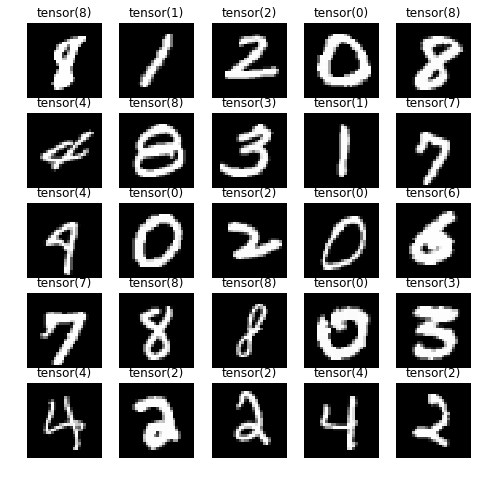

In [4]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = train_data[data_idx][1] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

## 5. 네트워크 설계

In [5]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.BatchNorm2d(8), nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.BatchNorm2d(16), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.BatchNorm2d(8), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 6. 모델 생성 및 loss function, optimizer 정의

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 7. Training

In [7]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # 코드 시작
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 코드 종료
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.8205
Epoch [1/5], Step [200/600], Loss: 0.4368
Epoch [1/5], Step [300/600], Loss: 0.2619


KeyboardInterrupt: 

## 8. Test

In [ ]:
fig = plt.figure(figsize=(28, 28))
model.eval()
with torch.no_grad():
    for i in range(1, 11):
        data_idx = np.random.randint(len(test_data))
        img = test_data[data_idx][0].to(device)
        img = torch.unsqueeze(img, 0)
        out = model(img)
        fig.add_subplot(10, 2, 2*i-1)
        plt.imshow(torch.squeeze(img).cpu().numpy(), cmap='gray')
        plt.axis('off')
        fig.add_subplot(10, 2, 2*i)
        plt.imshow(torch.squeeze(out).cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()
model.train()